In [19]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [52]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,24442,None,None,88456.944442
2020-06-13,24443,None,None,81711.812585
2020-06-14,24444,None,None,75478.449210
2020-06-15,24445,None,None,69775.401802
2020-06-16,24446,None,None,64776.457295
...,...,...,...,...
2021-01-13,24657,None,None,800107.339540
2021-01-14,24658,None,None,789855.287095
2021-01-15,24659,None,None,776109.050687


In [53]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-17_2021-01-17-19-19.pickle


In [54]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-16_2021-01-16-16-46.pickle


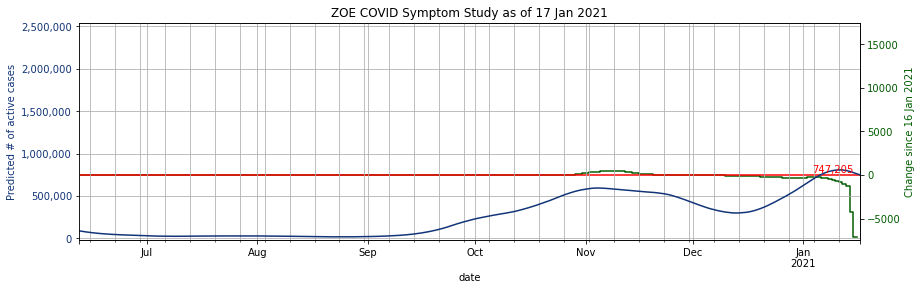

In [55]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

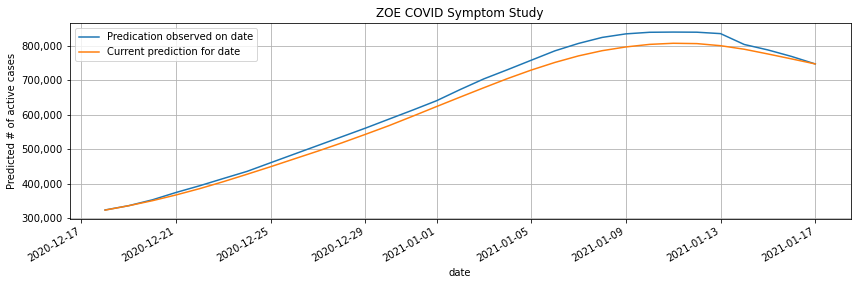

In [56]:
plot_study_evolution(curr_date, days=30)

In [57]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [58]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-01-17_2021-01-17-19-19.pickle


In [59]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
262,Worcester,E07000237,4.711232
124,Harlow,E07000073,4.519953
368,Merton,E09000024,3.261178
344,Cardiff,W06000015,3.003479
1,Middlesbrough,E06000002,2.958780
390,Dundee City,S12000042,2.942693
319,Greenwich,E09000011,2.810973
342,Bridgend,W06000013,2.790421
334,Wrexham,W06000006,2.766660
379,Tower Hamlets,E09000030,2.665783
